In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime, re, copy
import numpy as np
import statsmodels.formula.api as sm

df_nvda =pd.read_csv("NVDAcsvv.csv", decimal = ',')

In [2]:
df_nvda.head()

,Date,Open,Close,High,Low,Volume
0,4-Jan-16,32.290001,32.369999,32.580002,32.040001,8951900
1,5-Jan-16,32.98,32.889999,33.439999,32.5,12256800
2,6-Jan-16,32.349998,31.530001,32.5,31.16,11233600
3,7-Jan-16,30.74,30.280001,30.950001,29.879999,16132600
4,8-Jan-16,30.67,29.629999,30.700001,29.57,9961800


In [3]:
df_nvda.dtypes


Date      object
Open      object
Close     object
High      object
Low       object
Volume     int64
dtype: object

In [4]:
df_nvda['Volume'] = df_nvda['Volume'].astype(float)

In [5]:
df_nvda['Date']= pd.to_datetime(df_nvda['Date']) 
df_nvda.head()

,Date,Open,Close,High,Low,Volume
0,2016-01-04,32.290001,32.369999,32.580002,32.040001,8951900.0
1,2016-01-05,32.98,32.889999,33.439999,32.5,12256800.0
2,2016-01-06,32.349998,31.530001,32.5,31.16,11233600.0
3,2016-01-07,30.74,30.280001,30.950001,29.879999,16132600.0
4,2016-01-08,30.67,29.629999,30.700001,29.57,9961800.0


In [6]:
Volume = df_nvda['Volume']
#Close=df_nvda['Close']
Volume_Change= Volume.pct_change()*100
data_Volume = pd.DataFrame(Volume_Change)
data_Volume.rename( columns={"Volume_Change":"Volume_Change"}, inplace=True)

In [7]:
data_Volume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 1 columns):
Volume    877 non-null float64
dtypes: float64(1)
memory usage: 6.9 KB


In [8]:
data_Volume['Date']=df_nvda['Date']

In [9]:
data_Volume=data_Volume.dropna(axis=0)

In [10]:
data_Volume_threshold=data_Volume[data_Volume['Volume']>0] ##threshold applied

In [11]:
data_Volume_threshold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410 entries, 1 to 875
Data columns (total 2 columns):
Volume    410 non-null float64
Date      410 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.6 KB


In [12]:
def Kalman_Filter(Y):
    S = Y.shape[0]
    S = S + 1
   
    Z = param0[0]
    T = param0[1]
    H = param0[2]
    Q = param0[3]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    KF_Dens = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
            v[s]=Y[s-1]-Z*u_predict[s-1]   
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_update[s]; 
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
            KF_Dens[s] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]     
            Likelihood = np.sum(KF_Dens[1:-1])  
            return Likelihood


In [13]:
def Kalman_Smoother(params, Y):
    S = Y.shape[0]
    S = S + 1
    
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]

    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
            v[s]=Y[s-1]-Z*u_predict[s-1]   
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_update[s]; 
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q

        u_smooth = np.zeros(S)
        P_smooth = np.zeros(S)
        u_smooth[S-1] = u_update[S-1]
        P_smooth[S-1] = P_update[S-1]    
    for  t in range(S-1,0,-1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[t])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
    u_smooth = u_smooth[0:-1]
    return u_smooth

In [15]:
Volume_change=data_Volume['Volume'].astype(float).to_numpy()

In [16]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy import stats


/Users/manalisharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: OptimizeWarning: Unknown solver options: xtol
  after removing the cwd from sys.path.


Optimization terminated successfully.
         Current function value: 4.280007
         Iterations: 4
         Function evaluations: 48
         Gradient evaluations: 8


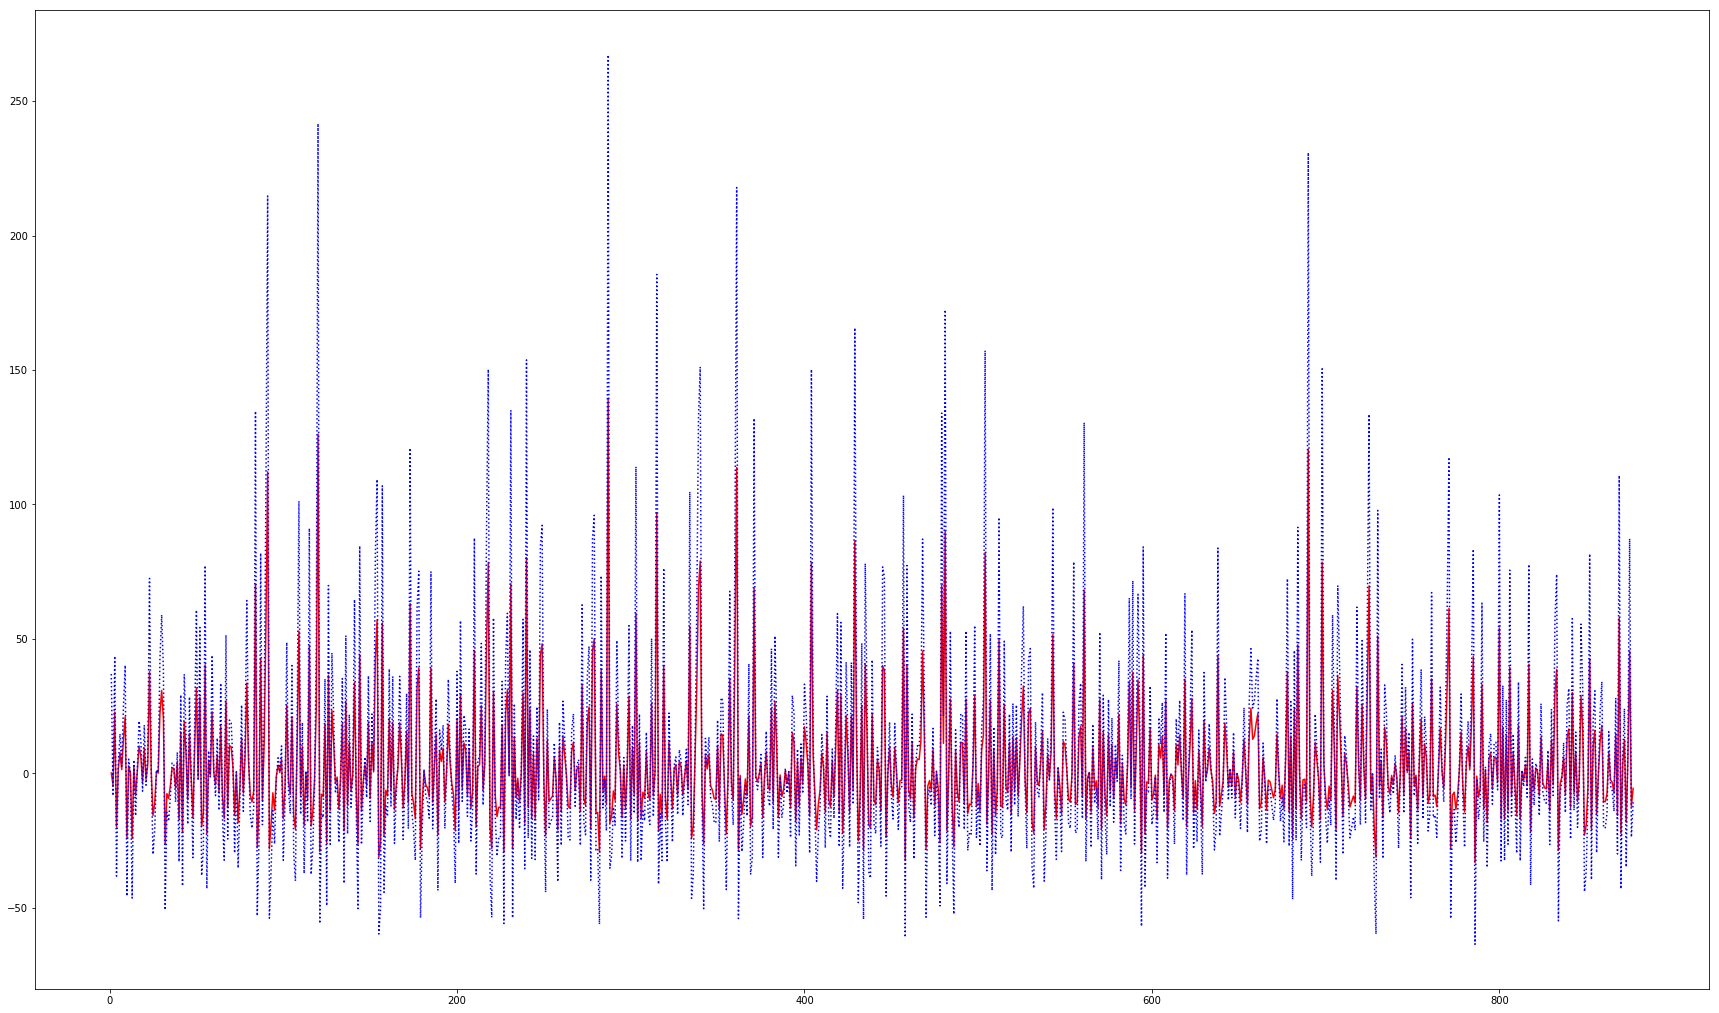

In [18]:
T =877
#Y = np.random.normal(0,1,T)
param0 = np.array([1.3, 0.7, 0.8, 1])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
u = Kalman_Smoother(param_star.x, Volume_change)
timevec = np.linspace(1,T,T)
fig = plt.figure(figsize=(30, 18))
plt.plot(timevec, u,'r',timevec, Volume_change,'b:')
plt.show()

In [33]:
Volume_change_1=data_Volume_threshold['Volume'].astype(float).to_numpy()

/Users/manalisharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: OptimizeWarning: Unknown solver options: xtol
  after removing the cwd from sys.path.


Optimization terminated successfully.
         Current function value: 4.280007
         Iterations: 4
         Function evaluations: 48
         Gradient evaluations: 8


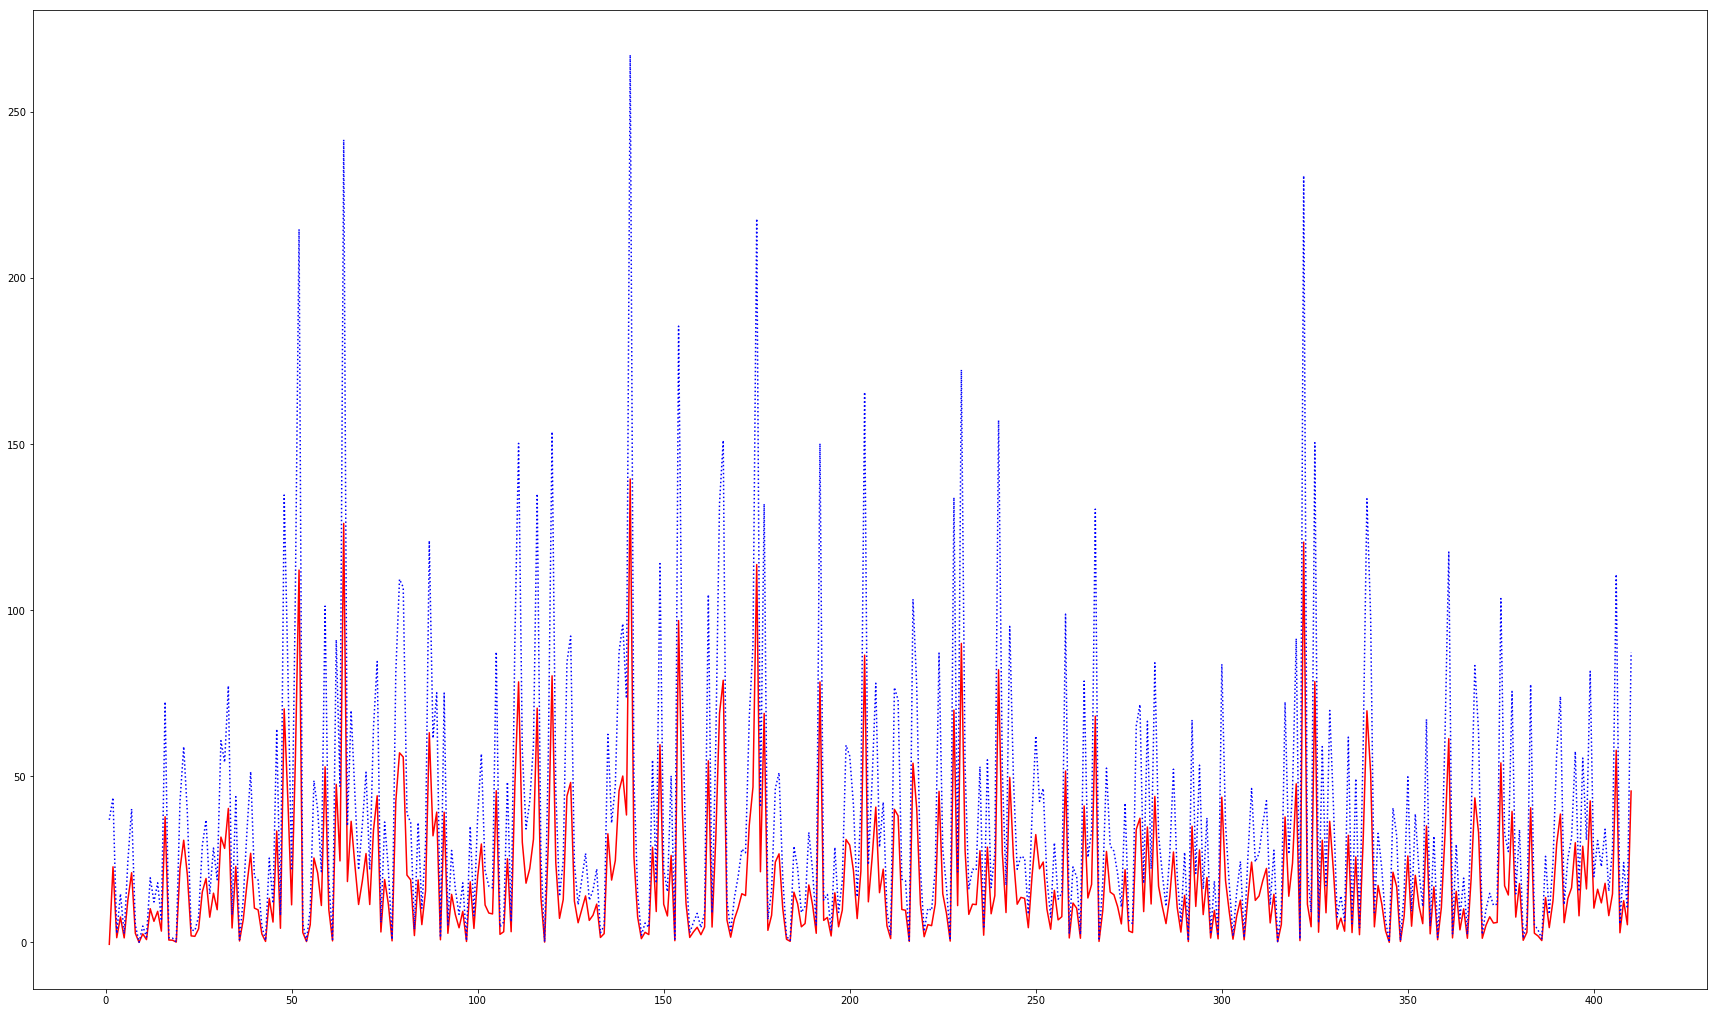

In [35]:
T = 410
#Y = np.random.normal(0,1,T)
param0 = np.array([1.3, 0.7, 0.8, 1])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
u = Kalman_Smoother(param_star.x, Volume_change_1)
timevec = np.linspace(1,T,T)
fig = plt.figure(figsize=(30, 18))
plt.plot(timevec, u,'r',timevec, Volume_change_1,'b:')
plt.show()